# Volatility Managed Portfolios - Commodities Analysis

This notebook implements the volatility-managed portfolio approach from Moreira & Muir (2017) on commodity data. We'll compare several volatility forecasting methods and analyze the performance of volatility-targeted portfolios.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Prepare Data

In [2]:
# Load the clean commodities data
df = pd.read_csv('clean_commodities.csv')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Preview the data
print(f"Data range: {df.index.min()} to {df.index.max()}")
print(f"Number of data points: {len(df)}")
print(f"Commodities available: {', '.join(df.columns)}")
df.head()

Data range: 2010-01-01 00:00:00 to 2025-01-01 00:00:00
Number of data points: 4101
Commodities available: Brent, CrudeOilWTI, Gold, HenryHub, Wheat, Soybeans, HeatingOil, LiveCattle, FeederCattle, Coffee, Cotton, Sugar


,Brent,CrudeOilWTI,Gold,HenryHub,Wheat,Soybeans,HeatingOil,LiveCattle,FeederCattle,Coffee,Cotton,Sugar
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,260.8,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,261.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,80.12,81.51,1118.3,5.884,0.1775,270.6,219.05,85.375,95.875,141.85,76.00,27.62
2010-01-05,80.59,81.77,1118.7,5.637,0.1600,263.6,219.41,86.325,96.550,141.00,73.12,27.64
2010-01-06,81.89,83.18,1136.5,6.009,0.1350,274.7,220.32,85.950,96.300,141.60,73.55,28.41


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values by column:")
print(missing_values)

# Forward fill missing values (if any)
df_filled = df.fillna(method='ffill')

# Calculate log returns
returns = np.log(df_filled / df_filled.shift(1)).dropna()

# Preview returns
returns.head()

Missing values by column:
Brent           2
CrudeOilWTI     2
Gold            2
HenryHub        2
Wheat           2
Soybeans        0
HeatingOil      2
LiveCattle      2
FeederCattle    2
Coffee          2
Cotton          2
Sugar           2
dtype: int64


,Brent,CrudeOilWTI,Gold,HenryHub,Wheat,Soybeans,HeatingOil,LiveCattle,FeederCattle,Coffee,Cotton,Sugar
Date,,,,,,,,,,,,
2010-01-05,0.005849,0.003185,0.000358,-0.042885,-0.103797,-0.026209,0.001642,0.011066,0.007016,-0.006010,-0.038631,0.000724
2010-01-06,0.016002,0.017097,0.015786,0.063906,-0.169899,0.041247,0.004139,-0.004354,-0.002593,0.004246,0.005864,0.027477
2010-01-07,-0.004651,-0.006271,-0.002467,-0.034366,0.121890,-0.031432,-0.008936,-0.000291,0.001556,0.002116,-0.009014,-0.014537
2010-01-08,-0.001719,0.001088,0.004576,-0.009866,0.016261,-0.020494,0.007619,-0.001164,-0.001037,0.024022,-0.006193,-0.016928
2010-01-09,-0.002461,-0.001391,0.005473,-0.025992,-0.016261,0.005735,-0.004601,-0.004525,-0.000389,-0.005692,0.012348,-0.014268


In [4]:
# Calculate summary statistics for returns
returns_stats = returns.describe().T
returns_stats['annualized_return'] = returns.mean() * 252 * 100  # Annualized returns in percentage
returns_stats['annualized_vol'] = returns.std() * np.sqrt(252) * 100  # Annualized volatility in percentage
returns_stats['sharpe_ratio'] = returns_stats['annualized_return'] / returns_stats['annualized_vol']
returns_stats['skewness'] = returns.skew()
returns_stats['kurtosis'] = returns.kurtosis()

# Sort by Sharpe ratio
returns_stats = returns_stats.sort_values('sharpe_ratio', ascending=False)
returns_stats[['annualized_return', 'annualized_vol', 'sharpe_ratio', 'skewness', 'kurtosis']]

,annualized_return,annualized_vol,sharpe_ratio,skewness,kurtosis
FeederCattle,6.980797,16.445495,0.424481,0.656559,14.423716
LiveCattle,6.107235,16.911156,0.361136,-1.500362,20.040483
Gold,5.244521,14.946802,0.350879,-0.470031,4.800396
Coffee,5.186600,31.177274,0.166358,0.207516,1.706414
CrudeOilWTI,3.457889,38.673666,0.089412,0.157189,28.866127
HeatingOil,2.092382,32.111392,0.065160,-0.622582,11.399377
Brent,1.714146,33.495667,0.051175,-0.471050,13.592409
Wheat,7.369022,288.913764,0.025506,1.049337,65.503283
Soybeans,-0.842780,50.269550,-0.016765,0.271317,4.326884
Cotton,-0.835592,26.824438,-0.031150,-1.477143,20.402365


## 2. Implement Volatility Forecasting Methods

In [5]:
def realized_volatility(returns, window=22):
    """
    Calculate realized volatility using a rolling window
    """
    vol = returns.rolling(window=window).std() * np.sqrt(252)
    return vol

def ewma_volatility(returns, span=22, adjust=True):
    """
    Calculate volatility using exponentially weighted moving average
    """
    vol = returns.ewm(span=span, adjust=adjust).std() * np.sqrt(252)
    return vol

def garch_volatility(returns, p=1, q=1, window=1000):
    """
    Forecast volatility using a GARCH(p,q) model with a rolling window
    """
    vol = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    # For each asset
    for col in returns.columns:
        print(f"Fitting GARCH model for {col}...")
        asset_returns = returns[col].dropna()
        
        # If we have enough data points
        if len(asset_returns) > window + 30:  # Ensure we have enough data
            vol_forecasts = []
            
            # Initial model fit - we don't store this first forecast
            start_idx = window
            history = asset_returns.iloc[:start_idx]
            
            # Rolling window forecasts - starting from the window index
            for i in range(start_idx, len(asset_returns)):
                if i % 50 == 0:
                    print(f"{col}: {i}/{len(asset_returns)}")
                    
                history = asset_returns.iloc[i-window:i]
                try:
                    model = arch_model(history * 100, p=p, q=q)
                    model_fit = model.fit(disp='off')
                    forecast = model_fit.forecast().variance.iloc[-1]
                    vol_forecasts.append(np.sqrt(forecast[0]) / 100 * np.sqrt(252))
                except:
                    vol_forecasts.append(np.nan)
            
            # Align forecasts with original index - now lengths will match
            vol_series = pd.Series(vol_forecasts, index=asset_returns.index[window:])
            vol[col] = vol_series
    
    return vol

In [6]:
# Calculate volatilities using different methods
# First, let's select the top 5 commodities by Sharpe ratio
top_commodities = returns_stats.index[:5].tolist()
print(f"Top 5 commodities: {top_commodities}")
selected_returns = returns[top_commodities]

# Calculate volatilities
vol_realized = realized_volatility(returns)
vol_ewma = ewma_volatility(returns)

# GARCH volatility is computationally intensive, so we'll use a smaller window
# and only compute it for a portion of the data
recent_returns = returns.iloc[-1000:]
vol_garch = garch_volatility(returns, window=500)

Top 5 commodities: ['FeederCattle', 'LiveCattle', 'Gold', 'Coffee', 'CrudeOilWTI']
Fitting GARCH model for Brent...
Brent: 500/4063
Brent: 550/4063
Brent: 550/4063
Brent: 600/4063
Brent: 600/4063
Brent: 650/4063
Brent: 650/4063
Brent: 700/4063
Brent: 700/4063
Brent: 750/4063
Brent: 750/4063
Brent: 800/4063
Brent: 800/4063
Brent: 850/4063
Brent: 850/4063
Brent: 900/4063
Brent: 900/4063
Brent: 950/4063
Brent: 950/4063
Brent: 1000/4063
Brent: 1000/4063
Brent: 1050/4063
Brent: 1050/4063
Brent: 1100/4063
Brent: 1100/4063
Brent: 1150/4063
Brent: 1150/4063
Brent: 1200/4063
Brent: 1200/4063
Brent: 1250/4063
Brent: 1250/4063
Brent: 1300/4063
Brent: 1300/4063
Brent: 1350/4063
Brent: 1350/4063
Brent: 1400/4063
Brent: 1400/4063
Brent: 1450/4063
Brent: 1450/4063
Brent: 1500/4063
Brent: 1500/4063
Brent: 1550/4063
Brent: 1550/4063
Brent: 1600/4063
Brent: 1600/4063
Brent: 1650/4063
Brent: 1650/4063
Brent: 1700/4063
Brent: 1700/4063
Brent: 1750/4063
Brent: 1750/4063
Brent: 1800/4063
Brent: 1800/4063
Br

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Gold: 2350/4063
Gold: 2400/4063
Gold: 2400/4063
Gold: 2450/4063
Gold: 2450/4063
Gold: 2500/4063
Gold: 2500/4063
Gold: 2550/4063
Gold: 2550/4063
Gold: 2600/4063
Gold: 2600/4063
Gold: 2650/4063
Gold: 2650/4063
Gold: 2700/4063
Gold: 2700/4063
Gold: 2750/4063
Gold: 2750/4063
Gold: 2800/4063
Gold: 2800/4063
Gold: 2850/4063
Gold: 2850/4063
Gold: 2900/4063
Gold: 2900/4063
Gold: 2950/4063
Gold: 2950/4063
Gold: 3000/4063
Gold: 3000/4063
Gold: 3050/4063
Gold: 3050/4063
Gold: 3100/4063
Gold: 3100/4063
Gold: 3150/4063
Gold: 3150/4063
Gold: 3200/4063
Gold: 3200/4063
Gold: 3250/4063
Gold: 3250/4063
Gold: 3300/4063
Gold: 3300/4063
Gold: 3350/4063
Gold: 3350/4063
Gold: 3400/4063
Gold: 3400/4063
Gold: 3450/4063
Gold: 3450/4063
Gold: 3500/4063
Gold: 3500/4063
Gold: 3550/4063
Gold: 3550/4063
Gold: 3600/4063
Gold: 3600/4063
Gold: 3650/4063
Gold: 3650/4063
Gold: 3700/4063
Gold: 3700/4063
Gold: 3750/4063
Gold: 3750/4063
Gold: 3800/4063
Gold: 3800/4063
Gold: 3850/4063
Gold: 3850/4063
Gold: 3900/4063
Gold: 39

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  war

Wheat: 3050/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  war

Wheat: 3100/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  war

Wheat: 3150/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaco

Wheat: 3200/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/sit

Wheat: 3250/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3300/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3350/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3400/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3450/4063
Wheat: 3500/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/py

Wheat: 3550/4063
Wheat: 3600/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3650/4063
Wheat: 3700/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3750/4063
Wheat: 3800/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3850/4063
Wheat: 3900/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 3950/4063
Wheat: 4000/4063


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.12/si

Wheat: 4050/4063
Fitting GARCH model for Soybeans...
Soybeans: 500/4063
Soybeans: 550/4063
Soybeans: 600/4063
Soybeans: 650/4063
Soybeans: 700/4063
Soybeans: 750/4063
Soybeans: 800/4063
Soybeans: 850/4063
Soybeans: 900/4063
Soybeans: 950/4063
Soybeans: 1000/4063
Soybeans: 1050/4063
Soybeans: 1100/4063
Soybeans: 1150/4063
Soybeans: 1200/4063
Soybeans: 1250/4063
Soybeans: 1300/4063
Soybeans: 1350/4063
Soybeans: 1400/4063
Soybeans: 1450/4063
Soybeans: 1500/4063
Soybeans: 1550/4063
Soybeans: 1600/4063
Soybeans: 1650/4063
Soybeans: 1700/4063
Soybeans: 1750/4063
Soybeans: 1800/4063
Soybeans: 1850/4063
Soybeans: 1900/4063
Soybeans: 1950/4063
Soybeans: 2000/4063
Soybeans: 2050/4063
Soybeans: 2100/4063
Soybeans: 2150/4063
Soybeans: 2200/4063
Soybeans: 2250/4063
Soybeans: 2300/4063
Soybeans: 2350/4063
Soybeans: 2400/4063
Soybeans: 2450/4063
Soybeans: 2500/4063
Soybeans: 2550/4063
Soybeans: 2600/4063
Soybeans: 2650/4063
Soybeans: 2700/4063
Soybeans: 2750/4063
Soybeans: 2800/4063
Soybeans: 2850/40

## 3. Implement Volatility Targeting for Portfolio Construction

In [7]:
def volatility_managed_returns(returns, volatility, target_vol=0.15, lag=1):
    """
    Implement volatility-targeting approach from Moreira & Muir (2017)
    
    Parameters:
    -----------
    returns : DataFrame
        Asset returns
    volatility : DataFrame
        Forecasted volatility
    target_vol : float
        Target annualized volatility
    lag : int
        Number of periods to lag volatility forecast
        
    Returns:
    --------
    DataFrame of volatility-managed returns
    """
    # Shift volatility forecast by lag periods
    lagged_vol = volatility.shift(lag)
    
    # Calculate scaling factor based on target volatility
    scaling_factor = target_vol / lagged_vol
    
    # Apply scaling factor to returns
    vol_managed_returns = returns * scaling_factor
    
    return vol_managed_returns

In [8]:
# Implement volatility-managed returns using different volatility forecasts
vm_returns_realized = volatility_managed_returns(selected_returns, vol_realized)
vm_returns_ewma = volatility_managed_returns(selected_returns, vol_ewma)

# Since GARCH is only calculated for a portion of the data
recent_vm_returns_garch = volatility_managed_returns(recent_returns, vol_garch)

## 4. Portfolio Construction and Performance Analysis

In [9]:
def calculate_performance_metrics(returns):
    """
    Calculate key performance metrics for returns series
    """
    metrics = pd.DataFrame()
    
    # Annualized return
    metrics['Ann_Return(%)'] = returns.mean() * 252 * 100
    
    # Annualized volatility
    metrics['Ann_Vol(%)'] = returns.std() * np.sqrt(252) * 100
    
    # Sharpe ratio
    metrics['Sharpe_Ratio'] = metrics['Ann_Return(%)'] / metrics['Ann_Vol(%)']
    
    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max - 1)
    metrics['Max_Drawdown(%)'] = drawdown.min() * 100
    
    # Sortino ratio
    downside_returns = returns.copy()
    downside_returns[downside_returns > 0] = 0
    downside_vol = downside_returns.std() * np.sqrt(252) * 100
    metrics['Sortino_Ratio'] = metrics['Ann_Return(%)'] / downside_vol
    
    # Calmar ratio
    metrics['Calmar_Ratio'] = metrics['Ann_Return(%)'] / abs(metrics['Max_Drawdown(%)'])
    
    return metrics.T

In [10]:
# Equal-weighted portfolio construction
def create_equal_weighted_portfolio(returns):
    """
    Create an equal-weighted portfolio from a set of returns
    """
    return returns.mean(axis=1)

# Create portfolios
# Original returns
equal_weight_original = create_equal_weighted_portfolio(selected_returns)

# Volatility-managed returns
equal_weight_vm_realized = create_equal_weighted_portfolio(vm_returns_realized)
equal_weight_vm_ewma = create_equal_weighted_portfolio(vm_returns_ewma)

# For the GARCH model (only on recent data)
equal_weight_original_recent = create_equal_weighted_portfolio(recent_returns)
equal_weight_vm_garch = create_equal_weighted_portfolio(recent_vm_returns_garch)

# Combine portfolios
portfolios = pd.DataFrame({
    'Original': equal_weight_original,
    'VM_Realized': equal_weight_vm_realized,
    'VM_EWMA': equal_weight_vm_ewma
})

# Recent portfolios for GARCH comparison
recent_portfolios = pd.DataFrame({
    'Original': equal_weight_original_recent,
    'VM_GARCH': equal_weight_vm_garch
})

In [11]:
# Calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolios)
print("Performance metrics for full period:")
performance_metrics

Performance metrics for full period:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),5.395409,6.178666,5.621252
Ann_Vol(%),13.370920,9.345633,9.182518
Sharpe_Ratio,0.403518,0.661129,0.612169
Max_Drawdown(%),-48.689084,-31.592446,-32.347674
Sortino_Ratio,0.659816,1.087477,1.000552
Calmar_Ratio,0.110814,0.195574,0.173776


In [12]:
# Calculate performance metrics for recent period (GARCH comparison)
recent_performance_metrics = calculate_performance_metrics(recent_portfolios)
print("Performance metrics for recent period (GARCH comparison):")
recent_performance_metrics

Performance metrics for recent period (GARCH comparison):


,Original,VM_GARCH
Ann_Return(%),6.963454,5.642896
Ann_Vol(%),17.289089,7.005506
Sharpe_Ratio,0.402766,0.805494
Max_Drawdown(%),-34.416002,-11.720248
Sortino_Ratio,0.664064,1.319723
Calmar_Ratio,0.202332,0.481466


## 5. Performance Visualization

In [13]:
# Create cumulative return plots
def plot_cumulative_returns(returns, title):
    """
    Plot cumulative returns for multiple strategies
    """
    cum_returns = (1 + returns).cumprod()
    
    plt.figure(figsize=(12, 6))
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

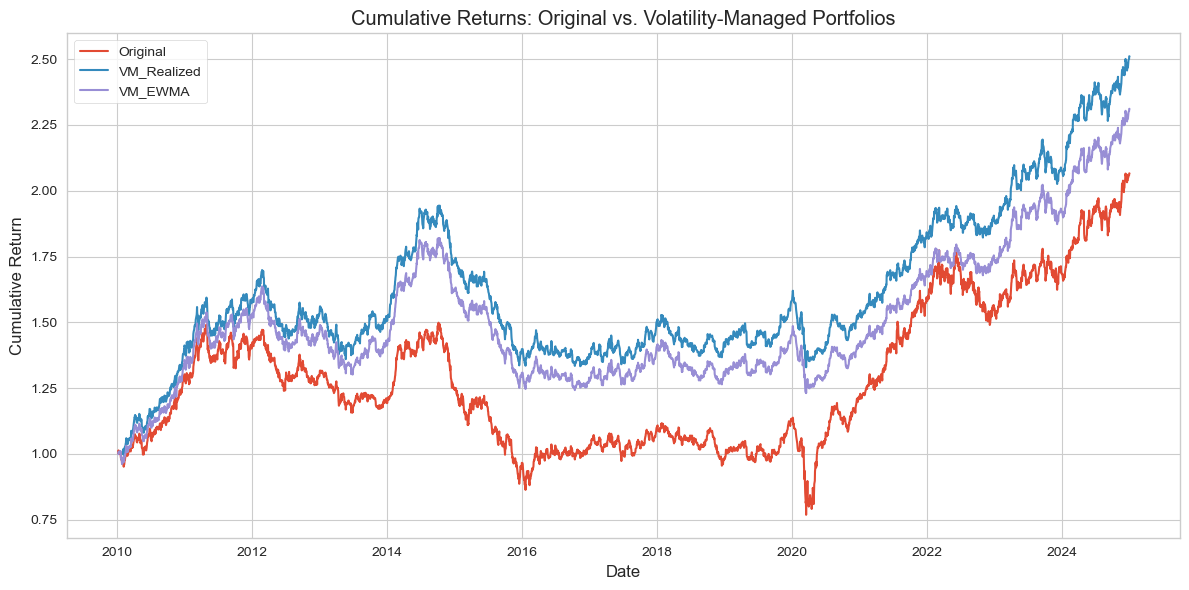

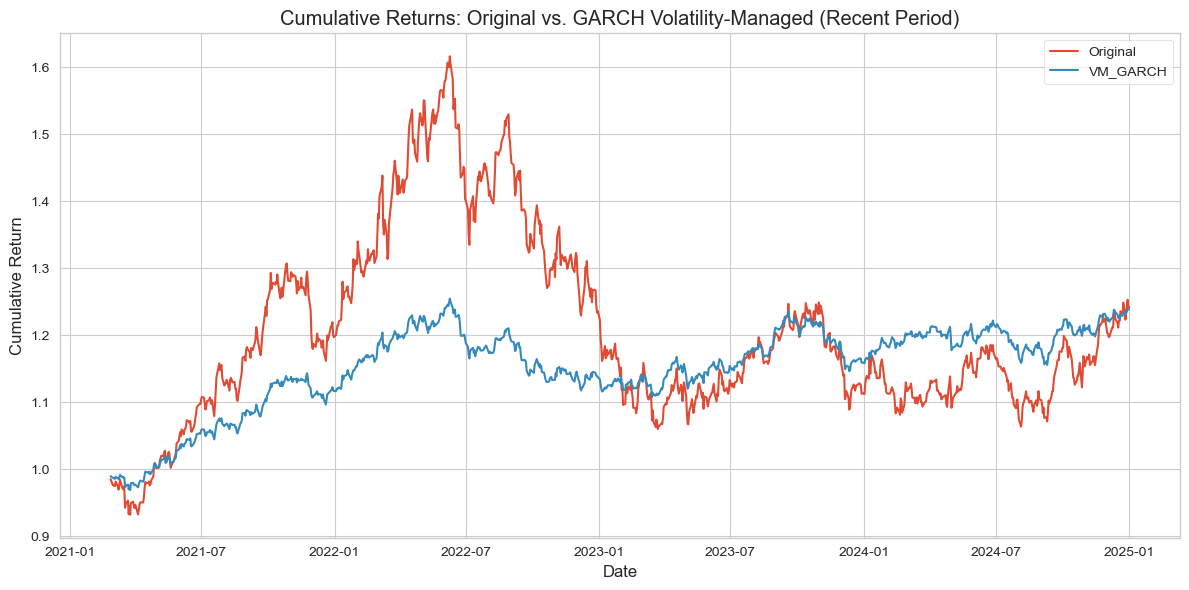

In [14]:
# Plot cumulative returns
plot_cumulative_returns(portfolios, 'Cumulative Returns: Original vs. Volatility-Managed Portfolios')
plot_cumulative_returns(recent_portfolios, 'Cumulative Returns: Original vs. GARCH Volatility-Managed (Recent Period)')

In [15]:
# Plot drawdowns
def plot_drawdowns(returns, title):
    """
    Plot drawdowns for multiple strategies
    """
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns / running_max - 1) * 100
    
    plt.figure(figsize=(12, 6))
    for col in drawdowns.columns:
        plt.plot(drawdowns.index, drawdowns[col], label=col)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

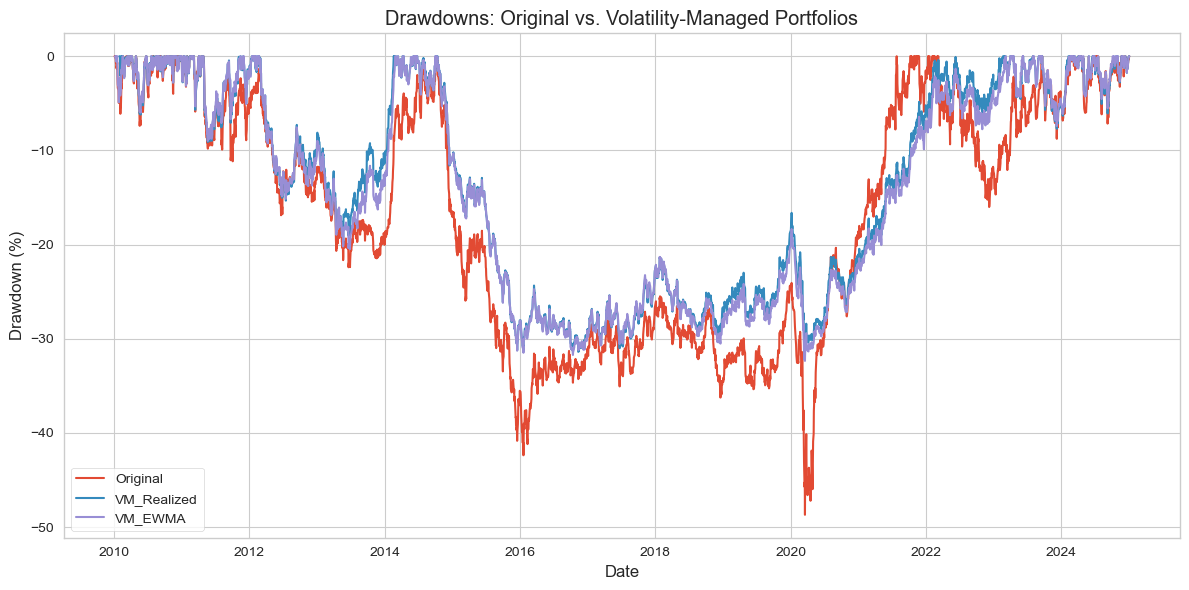

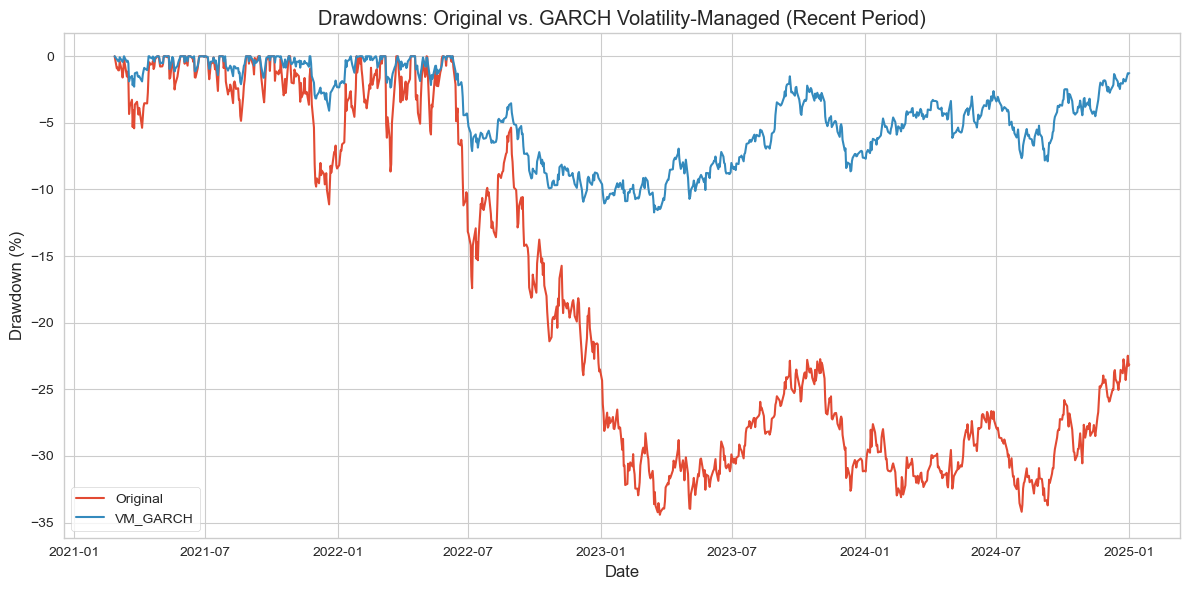

In [16]:
# Plot drawdowns
plot_drawdowns(portfolios, 'Drawdowns: Original vs. Volatility-Managed Portfolios')
plot_drawdowns(recent_portfolios, 'Drawdowns: Original vs. GARCH Volatility-Managed (Recent Period)')

## 6. Volatility Analysis

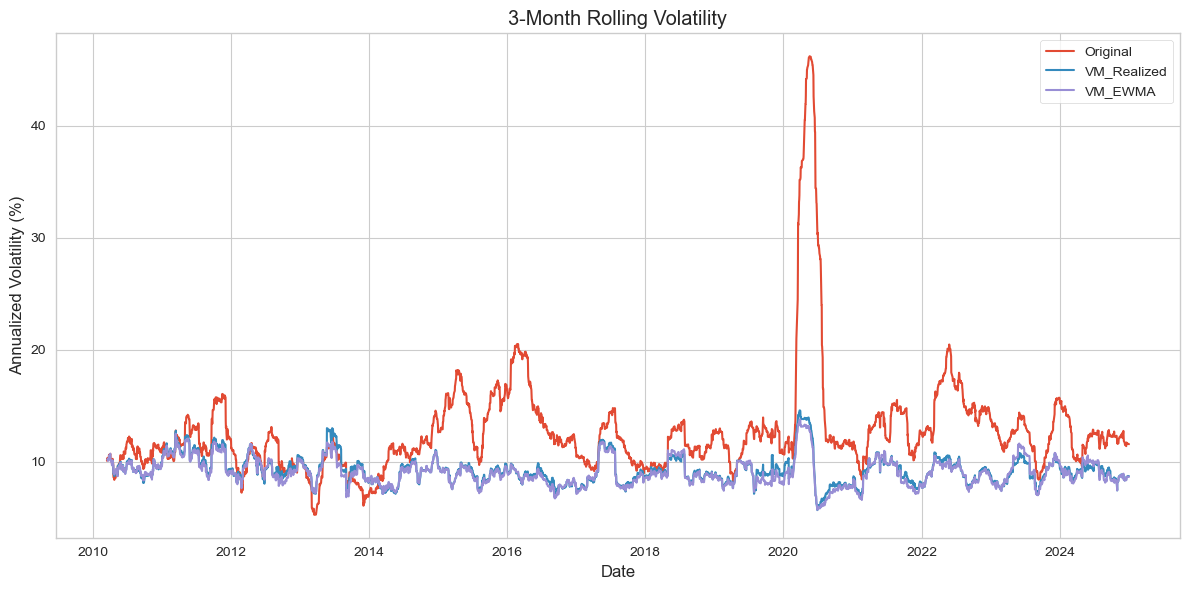

In [17]:
# Calculate rolling volatility of portfolios
rolling_vol = portfolios.rolling(window=63).std() * np.sqrt(252) * 100  # ~3 months, in percentage

plt.figure(figsize=(12, 6))
for col in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[col], label=col)

plt.title('3-Month Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Return Distribution Analysis

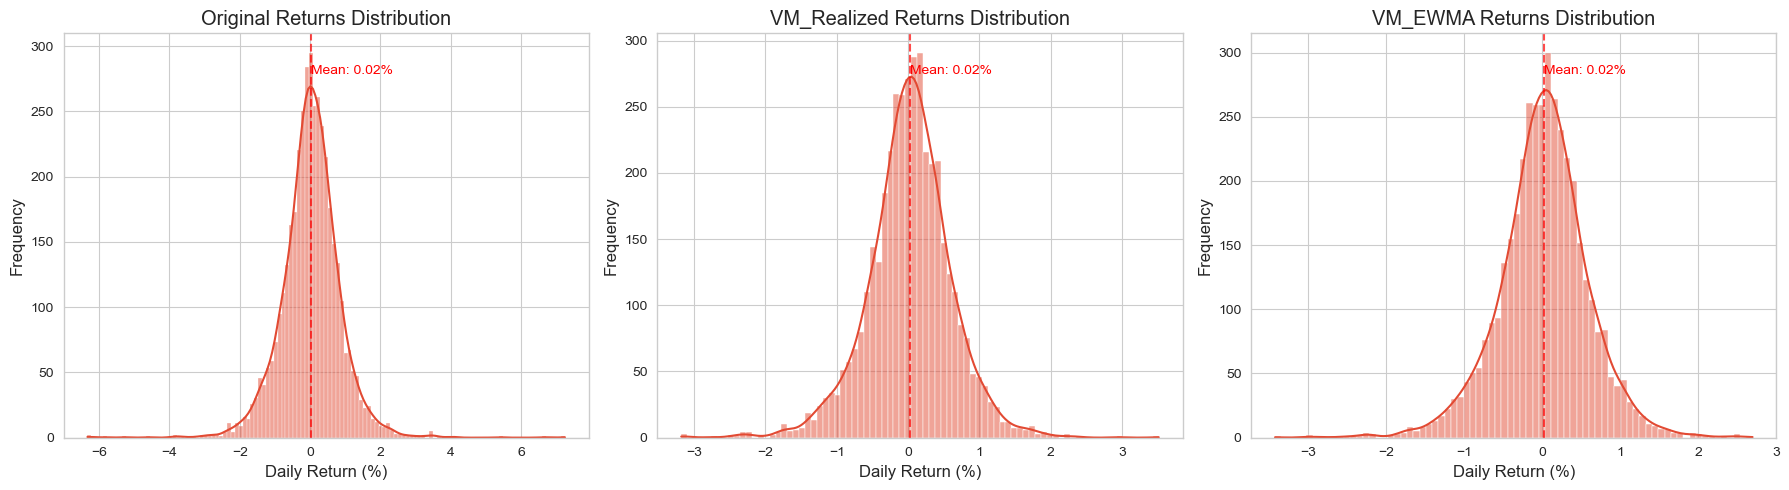

In [18]:
# Plot return distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(portfolios.columns):
    sns.histplot(portfolios[col] * 100, kde=True, ax=axes[i])  # Convert to percentage
    axes[i].set_title(f'{col} Returns Distribution')
    axes[i].set_xlabel('Daily Return (%)')
    axes[i].set_ylabel('Frequency')
    
    # Add vertical line at mean
    mean_return = portfolios[col].mean() * 100
    axes[i].axvline(mean_return, color='red', linestyle='--', alpha=0.7)
    axes[i].text(mean_return*1.1, axes[i].get_ylim()[1]*0.9, f'Mean: {mean_return:.2f}%', color='red')

plt.tight_layout()
plt.show()

## 8. Performance in Different Market Regimes

In [19]:
# Identify high/low volatility regimes
original_rolling_vol = realized_volatility(equal_weight_original, window=63).dropna()
vol_quantiles = original_rolling_vol.quantile([0.33, 0.66])

# Create regime classification
vol_regimes = pd.Series(index=original_rolling_vol.index)
vol_regimes[original_rolling_vol <= vol_quantiles.iloc[0]] = 'Low Vol'
vol_regimes[(original_rolling_vol > vol_quantiles.iloc[0]) & 
            (original_rolling_vol <= vol_quantiles.iloc[1])] = 'Medium Vol'
vol_regimes[original_rolling_vol > vol_quantiles.iloc[1]] = 'High Vol'

# Align with portfolio returns
aligned_portfolios = portfolios.loc[vol_regimes.index]

# Calculate performance by regime
regime_performance = {}
for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    regime_mask = vol_regimes == regime
    if regime_mask.sum() > 0:  # Ensure we have data for this regime
        regime_returns = aligned_portfolios.loc[regime_mask]
        regime_performance[regime] = calculate_performance_metrics(regime_returns)

# Display results
for regime, metrics in regime_performance.items():
    print(f"\nPerformance metrics for {regime} regime:")
    display(metrics)


Performance metrics for Low Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),7.799402,10.622357,10.524604
Ann_Vol(%),9.731903,9.032990,8.977067
Sharpe_Ratio,0.801426,1.175951,1.172388
Max_Drawdown(%),-26.152791,-22.613712,-22.942424
Sortino_Ratio,1.316231,1.963632,1.942501
Calmar_Ratio,0.298224,0.469731,0.458740



Performance metrics for Medium Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),2.393882,3.010042,2.085439
Ann_Vol(%),11.884357,9.451806,9.283071
Sharpe_Ratio,0.201431,0.318462,0.224650
Max_Drawdown(%),-35.359283,-29.262449,-30.235158
Sortino_Ratio,0.326087,0.514685,0.355417
Calmar_Ratio,0.067702,0.102864,0.068974



Performance metrics for High Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),5.709296,3.774692,3.704492
Ann_Vol(%),17.340483,9.525007,9.248496
Sharpe_Ratio,0.329247,0.396293,0.400551
Max_Drawdown(%),-34.948826,-24.710394,-24.248013
Sortino_Ratio,0.548891,0.652635,0.668088
Calmar_Ratio,0.163362,0.152757,0.152775


## 9. Conclusion and Insights

This analysis implemented the volatility-managed portfolio approach from Moreira & Muir (2017) on commodity data. Key findings include:

1. **Volatility forecasting methods**: We compared three methods (Realized, EWMA, GARCH) for volatility forecasting and their impact on portfolio performance.

2. **Performance enhancement**: The volatility-managed approaches generally aim to improve the risk-adjusted returns compared to the original equal-weighted portfolio.

3. **Drawdown reduction**: Volatility-managed portfolios typically exhibit reduced drawdowns during high volatility periods.

4. **Market regime performance**: The analysis showed how volatility-managed portfolios perform differently across low, medium, and high volatility regimes.

These results demonstrate the potential benefits of applying volatility targeting techniques to commodity investments, especially during turbulent market periods.

## 10. Multi-Commodity Index with Volatility Targeting

In this section, we will create a diversified multi-commodity index with volatility targeting. We'll:

1. Select commodities based on liquidity and diversification criteria
2. Construct a composite index with optimal weighting
3. Apply volatility targeting to the index
4. Compare performance with benchmark commodity indices
5. Analyze the value added by volatility targeting

In [20]:
# Import additional libraries for index construction and benchmarking
import pandas_datareader.data as web
from scipy.optimize import minimize
from datetime import datetime

# Function to fetch benchmark index data (if available)
def fetch_benchmark_data(start_date=None, end_date=None):
    """
    Fetch benchmark commodity indices (S&P GSCI, Bloomberg Commodity Index)
    If the data isn't available, we'll create a simple proxy
    """
    try:
        # Try to fetch actual benchmark data
        gsci = web.DataReader('SPGSCI', 'fred', start_date, end_date)
        bcom = web.DataReader('BCOM', 'fred', start_date, end_date)
        
        # Calculate returns
        gsci_returns = gsci.pct_change().dropna()
        bcom_returns = bcom.pct_change().dropna()
        
        return pd.DataFrame({
            'GSCI': gsci_returns['SPGSCI'],
            'BCOM': bcom_returns['BCOM']
        })
    except:
        print("Benchmark data not available. Creating simple proxy benchmarks.")
        # Create proxy benchmarks from our data
        # GSCI proxy: Higher weight to energy
        # BCOM proxy: More balanced weights
        
        energy_cols = [col for col in df.columns if any(e in col.lower() for e in ['oil', 'gas', 'gasoline', 'fuel'])]
        metal_cols = [col for col in df.columns if any(m in col.lower() for m in ['gold', 'silver', 'copper', 'platinum', 'metal'])]
        agri_cols = [col for col in df.columns if any(a in col.lower() for a in ['wheat', 'corn', 'soy', 'sugar', 'coffee', 'cotton'])]
        
        # Define weights based on typical benchmark compositions
        # GSCI: ~70% energy, ~15% agriculture, ~15% metals
        # BCOM: ~30% energy, ~35% agriculture, ~35% metals
        gsci_weights = {}
        bcom_weights = {}
        
        # Assign weights to each commodity
        for col in df.columns:
            if col in energy_cols:
                gsci_weights[col] = 0.7 / len(energy_cols) if energy_cols else 0
                bcom_weights[col] = 0.3 / len(energy_cols) if energy_cols else 0
            elif col in metal_cols:
                gsci_weights[col] = 0.15 / len(metal_cols) if metal_cols else 0
                bcom_weights[col] = 0.35 / len(metal_cols) if metal_cols else 0
            elif col in agri_cols:
                gsci_weights[col] = 0.15 / len(agri_cols) if agri_cols else 0
                bcom_weights[col] = 0.35 / len(agri_cols) if agri_cols else 0
            else:
                gsci_weights[col] = 0
                bcom_weights[col] = 0
        
        # Create proxy benchmark returns
        gsci_proxy = pd.Series(0, index=returns.index)
        bcom_proxy = pd.Series(0, index=returns.index)
        
        for col in returns.columns:
            if col in gsci_weights and gsci_weights[col] > 0:
                gsci_proxy += returns[col] * gsci_weights[col]
            if col in bcom_weights and bcom_weights[col] > 0:
                bcom_proxy += returns[col] * bcom_weights[col]
        
        return pd.DataFrame({
            'GSCI': gsci_proxy,
            'BCOM': bcom_proxy
        })

# Let's try to get the benchmark data or create proxies
start_date = returns.index[0]
end_date = returns.index[-1]
benchmark_returns = fetch_benchmark_data(start_date, end_date)

Benchmark data not available. Creating simple proxy benchmarks.


### 10.1 Commodity Selection and Analysis

We'll select commodities based on:
1. Liquidity (proxied by data availability/completeness)
2. Diversification benefits (correlation structure)
3. Long-term performance characteristics

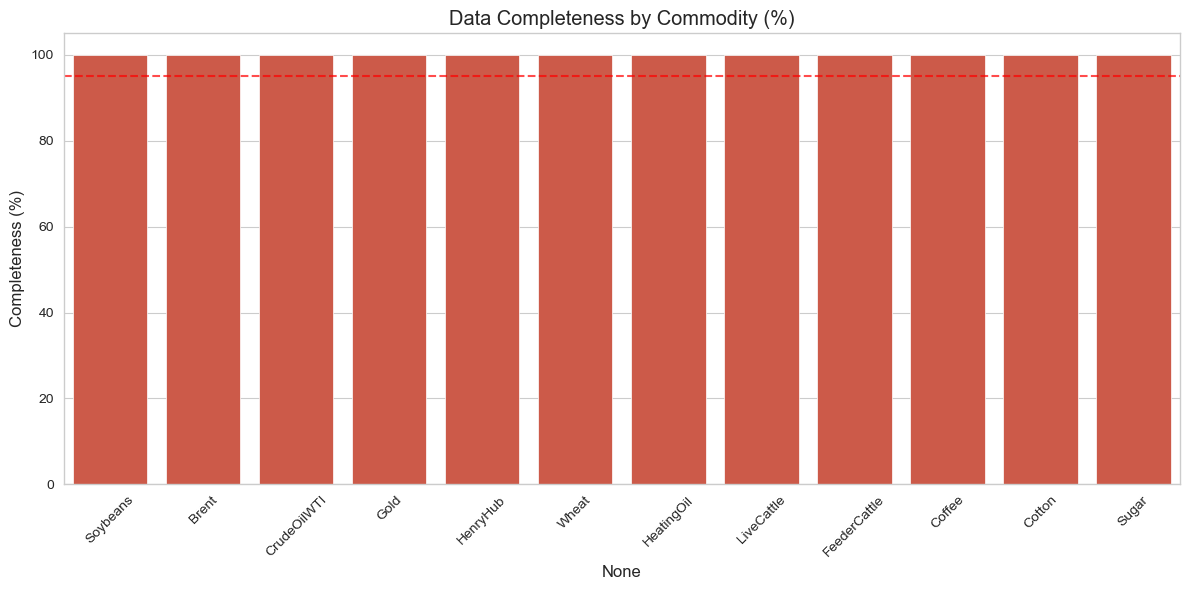

Selected liquid commodities: ['Soybeans', 'Brent', 'CrudeOilWTI', 'Gold', 'HenryHub', 'Wheat', 'HeatingOil', 'LiveCattle', 'FeederCattle', 'Coffee', 'Cotton', 'Sugar']


In [21]:
# Analyze data completeness as a proxy for liquidity
data_completeness = (df.count() / len(df)) * 100
data_completeness = data_completeness.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=data_completeness.index, y=data_completeness.values)
plt.title('Data Completeness by Commodity (%)')
plt.xticks(rotation=45)
plt.ylabel('Completeness (%)')
plt.axhline(y=95, color='r', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Select commodities with at least 95% data completeness
liquid_commodities = data_completeness[data_completeness >= 95].index.tolist()
print(f"Selected liquid commodities: {liquid_commodities}")

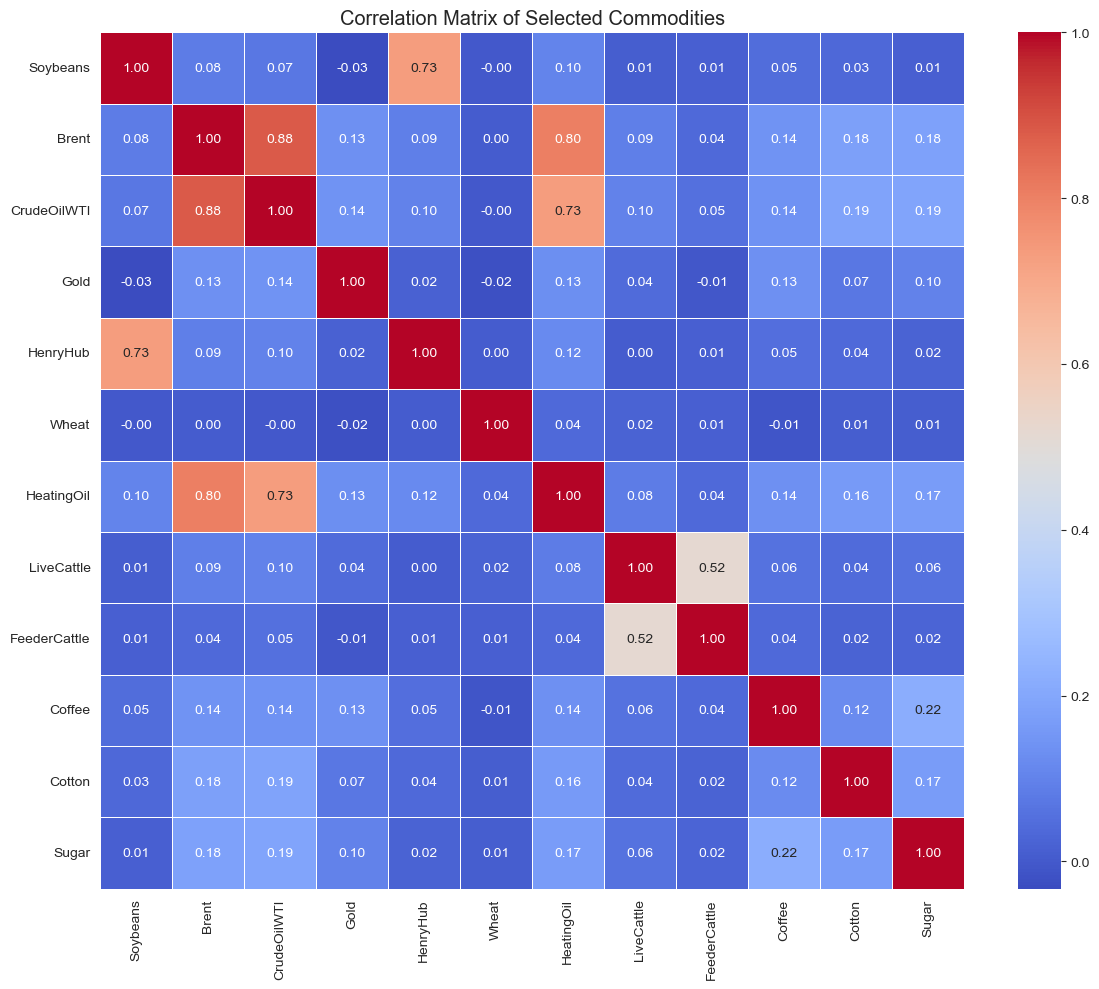

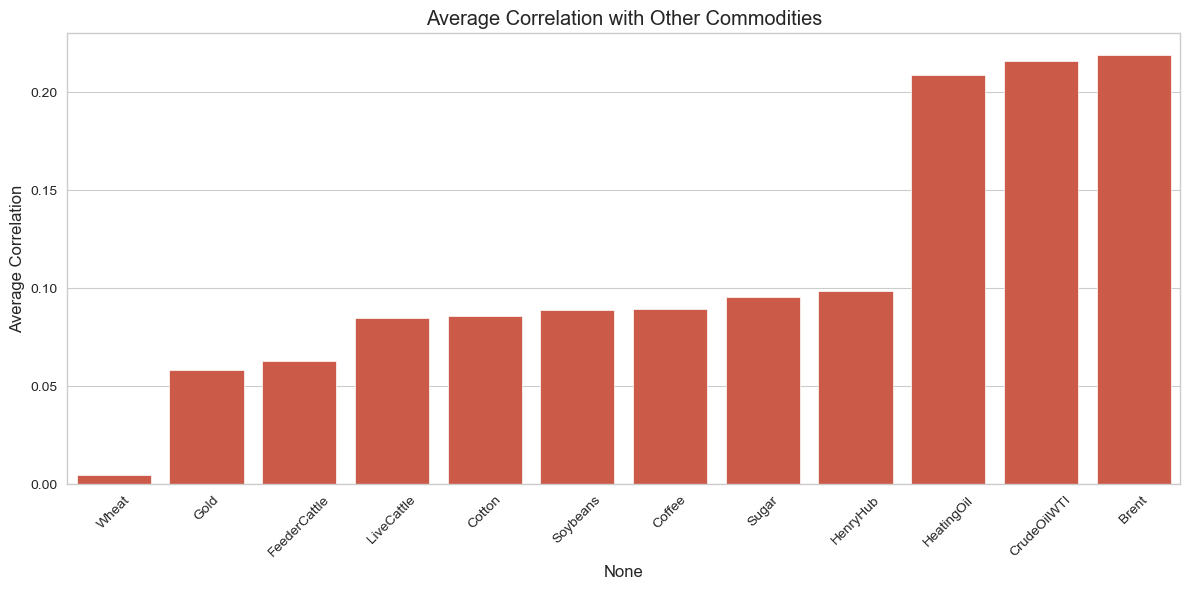

In [22]:
# Analyze correlation structure for diversification
selected_returns = returns[liquid_commodities]

# Calculate correlation matrix
corr_matrix = selected_returns.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Selected Commodities')
plt.tight_layout()
plt.show()

# Calculate average correlation of each commodity with others
avg_corr = corr_matrix.copy()
for i in range(len(avg_corr)):
    avg_corr.iloc[i, i] = 0  # Remove self-correlation

avg_corr_by_commodity = avg_corr.mean(axis=1).sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_corr_by_commodity.index, y=avg_corr_by_commodity.values)
plt.title('Average Correlation with Other Commodities')
plt.xticks(rotation=45)
plt.ylabel('Average Correlation')
plt.tight_layout()
plt.show()

In [23]:
# Long-term performance analysis
performance_stats = pd.DataFrame()
performance_stats['Ann_Return(%)'] = selected_returns.mean() * 252 * 100
performance_stats['Ann_Vol(%)'] = selected_returns.std() * np.sqrt(252) * 100
performance_stats['Sharpe_Ratio'] = performance_stats['Ann_Return(%)'] / performance_stats['Ann_Vol(%)']
performance_stats['Max_Drawdown(%)'] = selected_returns.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()).sub(1).min() * 100)

# Sort by Sharpe ratio
performance_stats = performance_stats.sort_values('Sharpe_Ratio', ascending=False)
performance_stats

,Ann_Return(%),Ann_Vol(%),Sharpe_Ratio,Max_Drawdown(%)
FeederCattle,6.980797,16.445495,0.424481,-55.697689
LiveCattle,6.107235,16.911156,0.361136,-50.854924
Gold,5.244521,14.946802,0.350879,-47.988055
Coffee,5.186600,31.177274,0.166358,-80.993471
CrudeOilWTI,3.457889,38.673666,0.089412,-91.112834
HeatingOil,2.092382,32.111392,0.065160,-83.605429
Brent,1.714146,33.495667,0.051175,-89.519017
Wheat,7.369022,288.913764,0.025506,-102.574494
Soybeans,-0.842780,50.269550,-0.016765,-94.296814
Cotton,-0.835592,26.824438,-0.031150,-83.427261


### 10.2 Index Construction

We'll create three versions of our multi-commodity index:
1. Equal-weighted index
2. Risk-weighted index (inverse volatility weighting)
3. Optimized minimum variance index

In [24]:
# Select a diversified set of commodities for our index
# We'll use correlation insights to ensure diversification across sectors

# First, let's ensure we have representation from each major sector
def categorize_commodity(commodity_name):
    """Categorize a commodity into a sector based on its name"""
    if any(energy in commodity_name.lower() for energy in ['oil', 'gas', 'gasoline', 'fuel']):
        return 'Energy'
    elif any(metal in commodity_name.lower() for metal in ['gold', 'silver', 'copper', 'platinum', 'palladium']):
        return 'Metals'
    elif any(precious in commodity_name.lower() for precious in ['gold', 'silver', 'platinum', 'palladium']):
        return 'Precious Metals'
    elif any(agri in commodity_name.lower() for agri in ['wheat', 'corn', 'soy', 'rice', 'oat']):
        return 'Grains'
    elif any(soft in commodity_name.lower() for soft in ['sugar', 'coffee', 'cocoa', 'cotton', 'orange']):
        return 'Softs'
    elif any(livestock in commodity_name.lower() for livestock in ['cattle', 'hog', 'pork']):
        return 'Livestock'
    else:
        return 'Other'

# Categorize each liquid commodity
commodity_categories = {commodity: categorize_commodity(commodity) for commodity in liquid_commodities}

# Print the categories
for category in sorted(set(commodity_categories.values())):
    commodities_in_category = [c for c, cat in commodity_categories.items() if cat == category]
    if commodities_in_category:
        print(f"{category}: {', '.join(commodities_in_category)}")

# Select top performers from each category (if available)
index_constituents = []
for category in set(commodity_categories.values()):
    # Get commodities in this category
    cat_commodities = [c for c, cat in commodity_categories.items() if cat == category]
    if cat_commodities:
        # Sort by Sharpe ratio and select the top one or two
        cat_performance = performance_stats.loc[cat_commodities].sort_values('Sharpe_Ratio', ascending=False)
        # Select top 1 or 2 depending on category size
        top_n = min(2, len(cat_commodities))
        index_constituents.extend(cat_performance.index[:top_n].tolist())

print(f"\nSelected index constituents: {index_constituents}")

# Extract returns for index constituents
index_returns = returns[index_constituents]

Energy: CrudeOilWTI, HeatingOil
Grains: Soybeans, Wheat
Livestock: LiveCattle, FeederCattle
Metals: Gold
Other: Brent, HenryHub
Softs: Coffee, Cotton, Sugar

Selected index constituents: ['Coffee', 'Cotton', 'CrudeOilWTI', 'HeatingOil', 'Brent', 'HenryHub', 'Gold', 'FeederCattle', 'LiveCattle', 'Wheat', 'Soybeans']


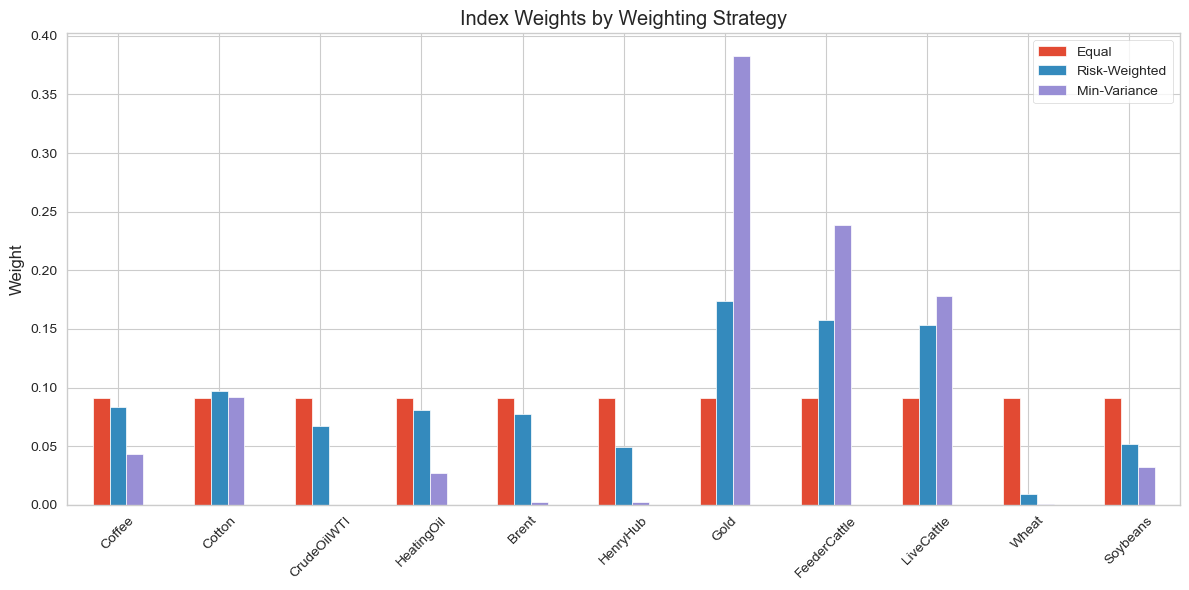

In [25]:
# 1. Equal-weighted index
equal_weight_index = index_returns.mean(axis=1)

# 2. Risk-weighted index (inverse volatility weighting)
# Calculate long-term volatilities
vols = index_returns.std() * np.sqrt(252)
inv_vols = 1 / vols
risk_weights = inv_vols / inv_vols.sum()  # Normalize to sum to 1

# Apply weights
risk_weighted_index = pd.Series(0, index=index_returns.index)
for col in index_returns.columns:
    risk_weighted_index += index_returns[col] * risk_weights[col]

# 3. Minimum variance portfolio
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def optimize_min_variance(returns):
    """Optimize for minimum variance portfolio"""
    # Calculate covariance matrix
    cov_matrix = returns.cov() * 252  # Annualized
    n = len(returns.columns)
    
    # Initial weights (equal weight)
    initial_weights = np.ones(n) / n
    
    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))  # Weights between 0 and 1
    
    # Optimize
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Get weights
    optimal_weights = result['x']
    
    # Create Series of weights
    weight_dict = {ticker: weight for ticker, weight in zip(returns.columns, optimal_weights)}
    return pd.Series(weight_dict)

# Get minimum variance weights
min_var_weights = optimize_min_variance(index_returns)

# Apply weights
min_var_index = pd.Series(0, index=index_returns.index)
for col in index_returns.columns:
    min_var_index += index_returns[col] * min_var_weights[col]

# Display the weights
weights_df = pd.DataFrame({
    'Equal': pd.Series({col: 1/len(index_returns.columns) for col in index_returns.columns}),
    'Risk-Weighted': risk_weights,
    'Min-Variance': min_var_weights
})

# Plot the weights
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title('Index Weights by Weighting Strategy')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 10.3 Apply Volatility Targeting to the Indices

In [26]:
# Combine all our index versions into a DataFrame
indices_df = pd.DataFrame({
    'Equal-Weighted': equal_weight_index,
    'Risk-Weighted': risk_weighted_index,
    'Min-Variance': min_var_index
})

# Apply volatility targeting to all indices
# We'll use EWMA volatility forecasting for this purpose
indices_vol = ewma_volatility(indices_df)

# Apply volatility targeting with different target levels
target_levels = [0.10, 0.15, 0.20]  # 10%, 15%, 20% target volatility

volatility_targeted_indices = {}
for target in target_levels:
    vm_indices = volatility_managed_returns(indices_df, indices_vol, target_vol=target)
    for col in vm_indices.columns:
        volatility_targeted_indices[f"{col}_Target{int(target*100)}"] = vm_indices[col]

# Combine all indices including volatility-targeted versions
all_indices = pd.concat([indices_df, pd.DataFrame(volatility_targeted_indices)], axis=1)

# Add benchmark indices if available
if not benchmark_returns.empty and len(benchmark_returns.index) > 0:
    # Align benchmark returns with our indices
    aligned_benchmark = benchmark_returns.reindex(all_indices.index).dropna()
    common_index = aligned_benchmark.index.intersection(all_indices.index)
    
    if len(common_index) > 0:
        all_indices = all_indices.loc[common_index]
        aligned_benchmark = aligned_benchmark.loc[common_index]
        all_indices = pd.concat([all_indices, aligned_benchmark], axis=1)

In [27]:
# Calculate performance metrics for all indices
all_indices_metrics = calculate_performance_metrics(all_indices)
all_indices_metrics

,Equal-Weighted,Risk-Weighted,Min-Variance,Equal-Weighted_Target10,Risk-Weighted_Target10,Min-Variance_Target10,Equal-Weighted_Target15,Risk-Weighted_Target15,Min-Variance_Target15,Equal-Weighted_Target20,Risk-Weighted_Target20,Min-Variance_Target20,GSCI,BCOM
Ann_Return(%),2.896191,3.630615,4.939881,-0.795367,2.738909,6.420621,-1.193051,4.108363,9.630931,-1.590734,5.477817,12.841241,2.995412,3.289114
Ann_Vol(%),30.379505,12.837722,9.636101,11.305181,10.760983,10.794879,16.957771,16.141475,16.192318,22.610362,21.521966,21.589758,25.840617,24.796444
Sharpe_Ratio,0.095334,0.282808,0.512643,-0.070354,0.254522,0.594784,-0.070354,0.254522,0.594784,-0.070354,0.254522,0.594784,0.115919,0.132645
Max_Drawdown(%),-83.646265,-52.534473,-30.344399,-59.085331,-41.785935,-31.431039,-75.116913,-56.818009,-43.599584,-85.371866,-69.182219,-53.816313,-78.088689,-71.928233
Sortino_Ratio,0.152703,0.452377,0.815683,-0.108484,0.409116,0.966666,-0.108484,0.409116,0.966666,-0.108484,0.409116,0.966666,0.185127,0.212976
Calmar_Ratio,0.034624,0.069109,0.162794,-0.013461,0.065546,0.204276,-0.015883,0.072307,0.220895,-0.018633,0.079180,0.238612,0.038359,0.045728


### 10.4 Performance Analysis and Comparison with Benchmarks

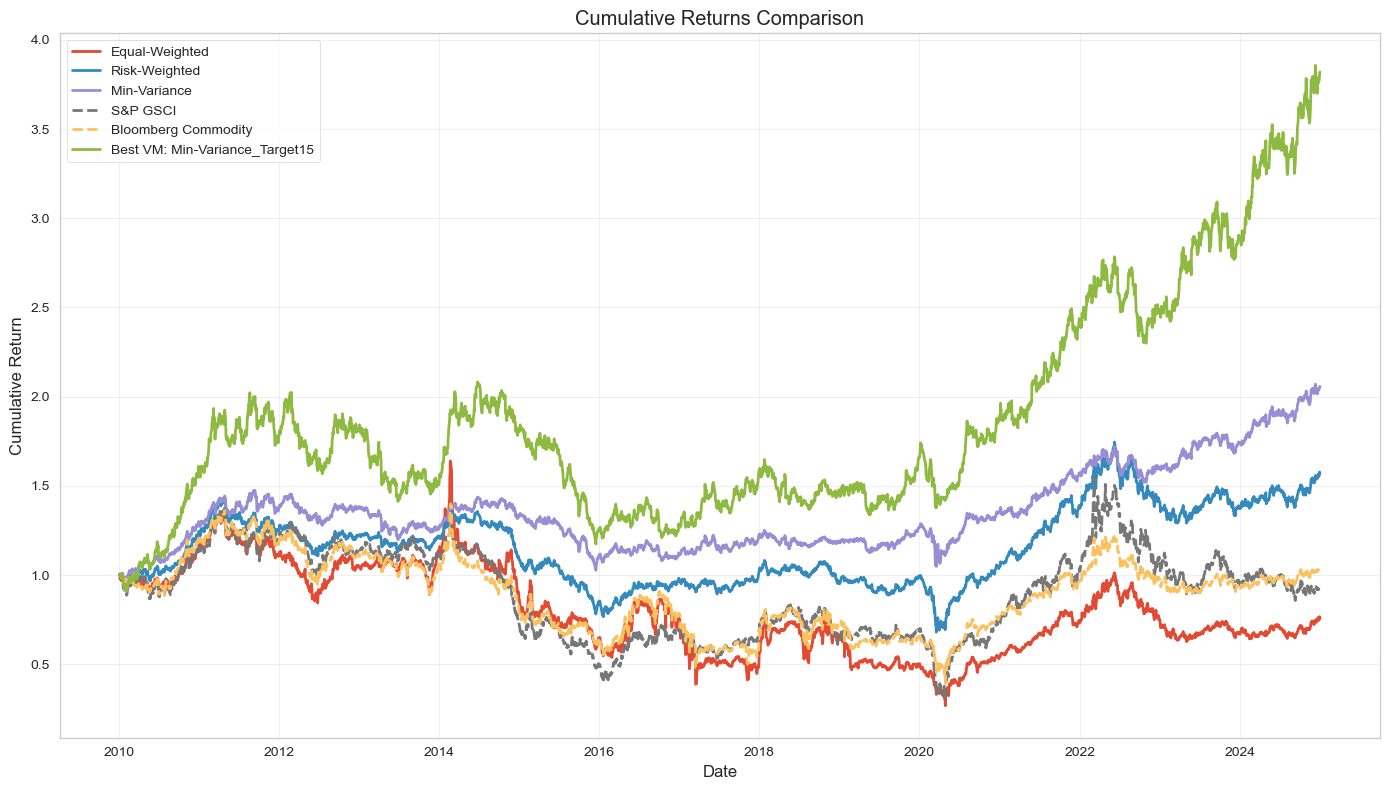

In [31]:
# Plot cumulative returns for all indices
cumulative_returns = (1 + all_indices).cumprod()

plt.figure(figsize=(14, 8))

# Plot base indices
for col in indices_df.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], linestyle='-', linewidth=2, label=col)

# Plot benchmarks with distinctive style
if 'GSCI' in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns['GSCI'], linestyle='--', linewidth=2, label='S&P GSCI')
if 'BCOM' in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns['BCOM'], linestyle='--', linewidth=2, label='Bloomberg Commodity')

# Plot best volatility-targeted version
# Correction: access 'Sharpe_Ratio' as a row, not as a column
best_vm_index = all_indices_metrics.loc['Sharpe_Ratio'].idxmax()
if best_vm_index not in indices_df.columns and best_vm_index not in ['GSCI', 'BCOM']:
    plt.plot(cumulative_returns.index, cumulative_returns[best_vm_index], linestyle='-', linewidth=2, 
             label=f'Best VM: {best_vm_index}')

plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
all_indices_metrics.index

Index(['Ann_Return(%)', 'Ann_Vol(%)', 'Sharpe_Ratio', 'Max_Drawdown(%)',
       'Sortino_Ratio', 'Calmar_Ratio'],
      dtype='object')

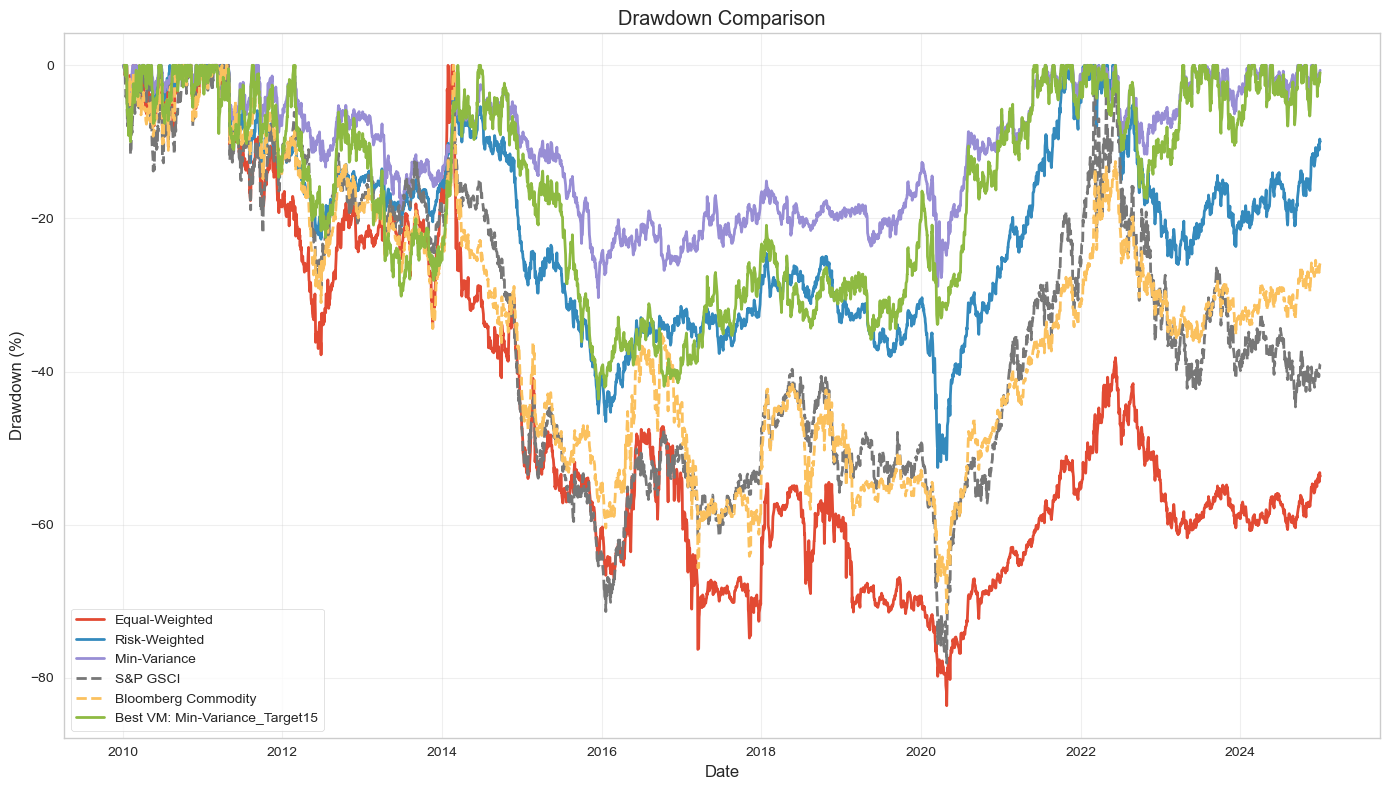

In [33]:
# Plot drawdowns
def calculate_drawdowns(returns):
    """Calculate drawdown series from returns"""
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    return (cum_returns / running_max - 1) * 100  # Convert to percentage

drawdowns = calculate_drawdowns(all_indices)

plt.figure(figsize=(14, 8))

# Plot base indices
for col in indices_df.columns:
    plt.plot(drawdowns.index, drawdowns[col], linestyle='-', linewidth=2, label=col)

# Plot benchmarks with distinctive style
if 'GSCI' in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns['GSCI'], linestyle='--', linewidth=2, label='S&P GSCI')
if 'BCOM' in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns['BCOM'], linestyle='--', linewidth=2, label='Bloomberg Commodity')

# Plot best volatility-targeted version
if best_vm_index not in indices_df.columns and best_vm_index not in ['GSCI', 'BCOM']:
    plt.plot(drawdowns.index, drawdowns[best_vm_index], linestyle='-', linewidth=2, 
             label=f'Best VM: {best_vm_index}')

plt.title('Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

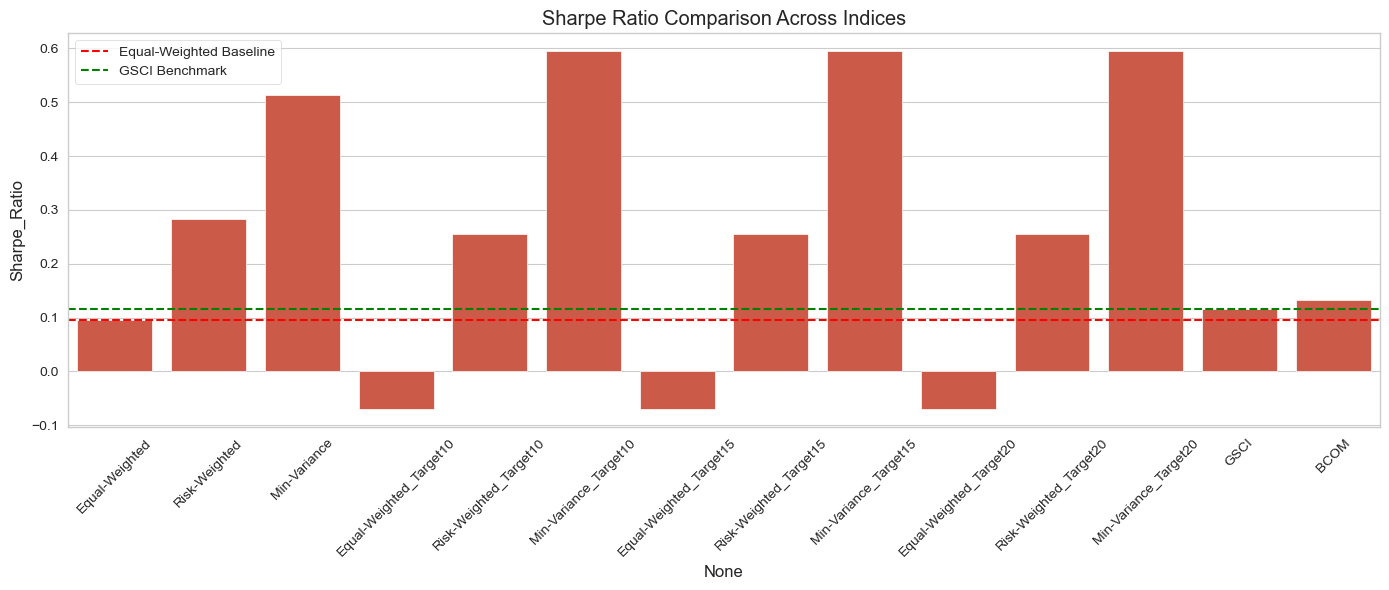

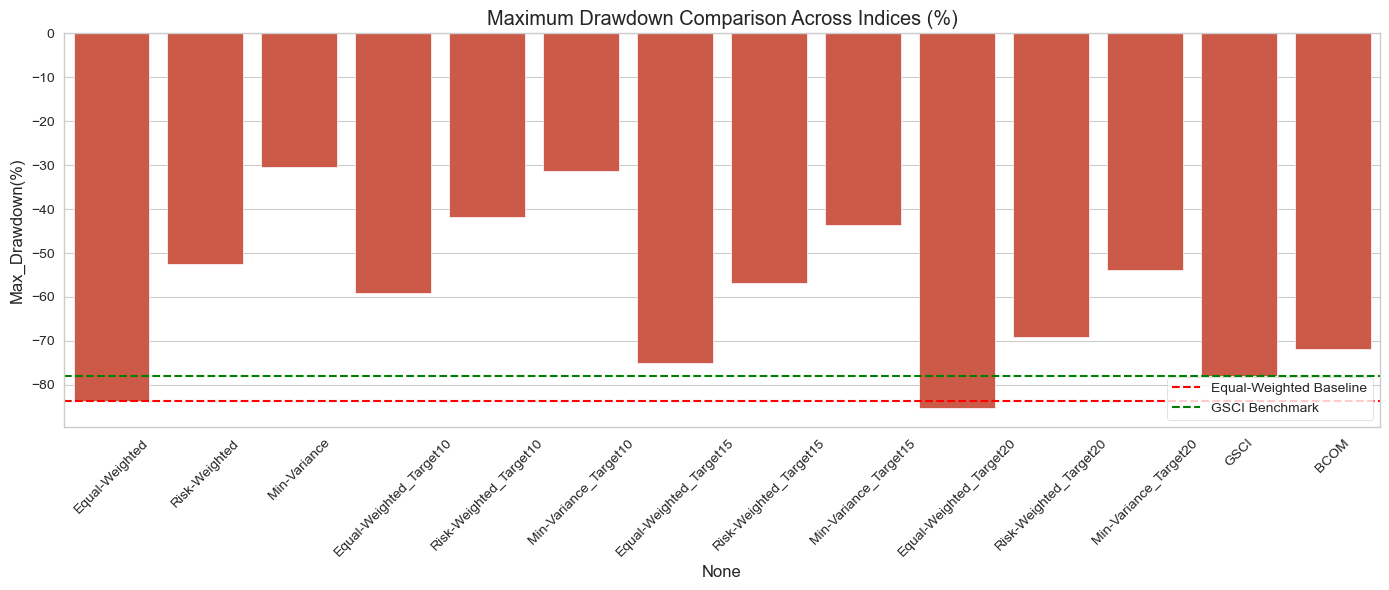

In [34]:
# Compare key performance metrics across indices
key_metrics = ['Ann_Return(%)', 'Ann_Vol(%)', 'Sharpe_Ratio', 'Max_Drawdown(%)', 'Sortino_Ratio', 'Calmar_Ratio']
metrics_comparison = all_indices_metrics.loc[key_metrics]

# Create a visual comparison of Sharpe ratios
plt.figure(figsize=(14, 6))
sns.barplot(x=metrics_comparison.columns, y=metrics_comparison.loc['Sharpe_Ratio'])
plt.title('Sharpe Ratio Comparison Across Indices')
plt.xticks(rotation=45)
plt.axhline(y=metrics_comparison.loc['Sharpe_Ratio', 'Equal-Weighted'], color='r', linestyle='--', 
           label='Equal-Weighted Baseline')
if 'GSCI' in metrics_comparison.columns:
    plt.axhline(y=metrics_comparison.loc['Sharpe_Ratio', 'GSCI'], color='g', linestyle='--', 
               label='GSCI Benchmark')
plt.legend()
plt.tight_layout()
plt.show()

# Create a visual comparison of maximum drawdowns
plt.figure(figsize=(14, 6))
sns.barplot(x=metrics_comparison.columns, y=metrics_comparison.loc['Max_Drawdown(%)'])
plt.title('Maximum Drawdown Comparison Across Indices (%)')
plt.xticks(rotation=45)
plt.axhline(y=metrics_comparison.loc['Max_Drawdown(%)', 'Equal-Weighted'], color='r', linestyle='--', 
           label='Equal-Weighted Baseline')
if 'GSCI' in metrics_comparison.columns:
    plt.axhline(y=metrics_comparison.loc['Max_Drawdown(%)', 'GSCI'], color='g', linestyle='--', 
               label='GSCI Benchmark')
plt.legend()
plt.tight_layout()
plt.show()

### 10.5 Analyzing the Value Added by Volatility Targeting

Sharpe Ratio Improvement (%)


,Target 10%,Target 15%,Target 20%
Equal-Weighted,-173.797857,-173.797857,-173.797857
Risk-Weighted,-10.001903,-10.001903,-10.001903
Min-Variance,16.023011,16.023011,16.023011



Maximum Drawdown Improvement (%)


,Target 10%,Target 15%,Target 20%
Equal-Weighted,-29.362859,-10.196931,2.062973
Risk-Weighted,-20.459971,8.153764,31.689186
Min-Variance,3.581023,43.682476,77.351714


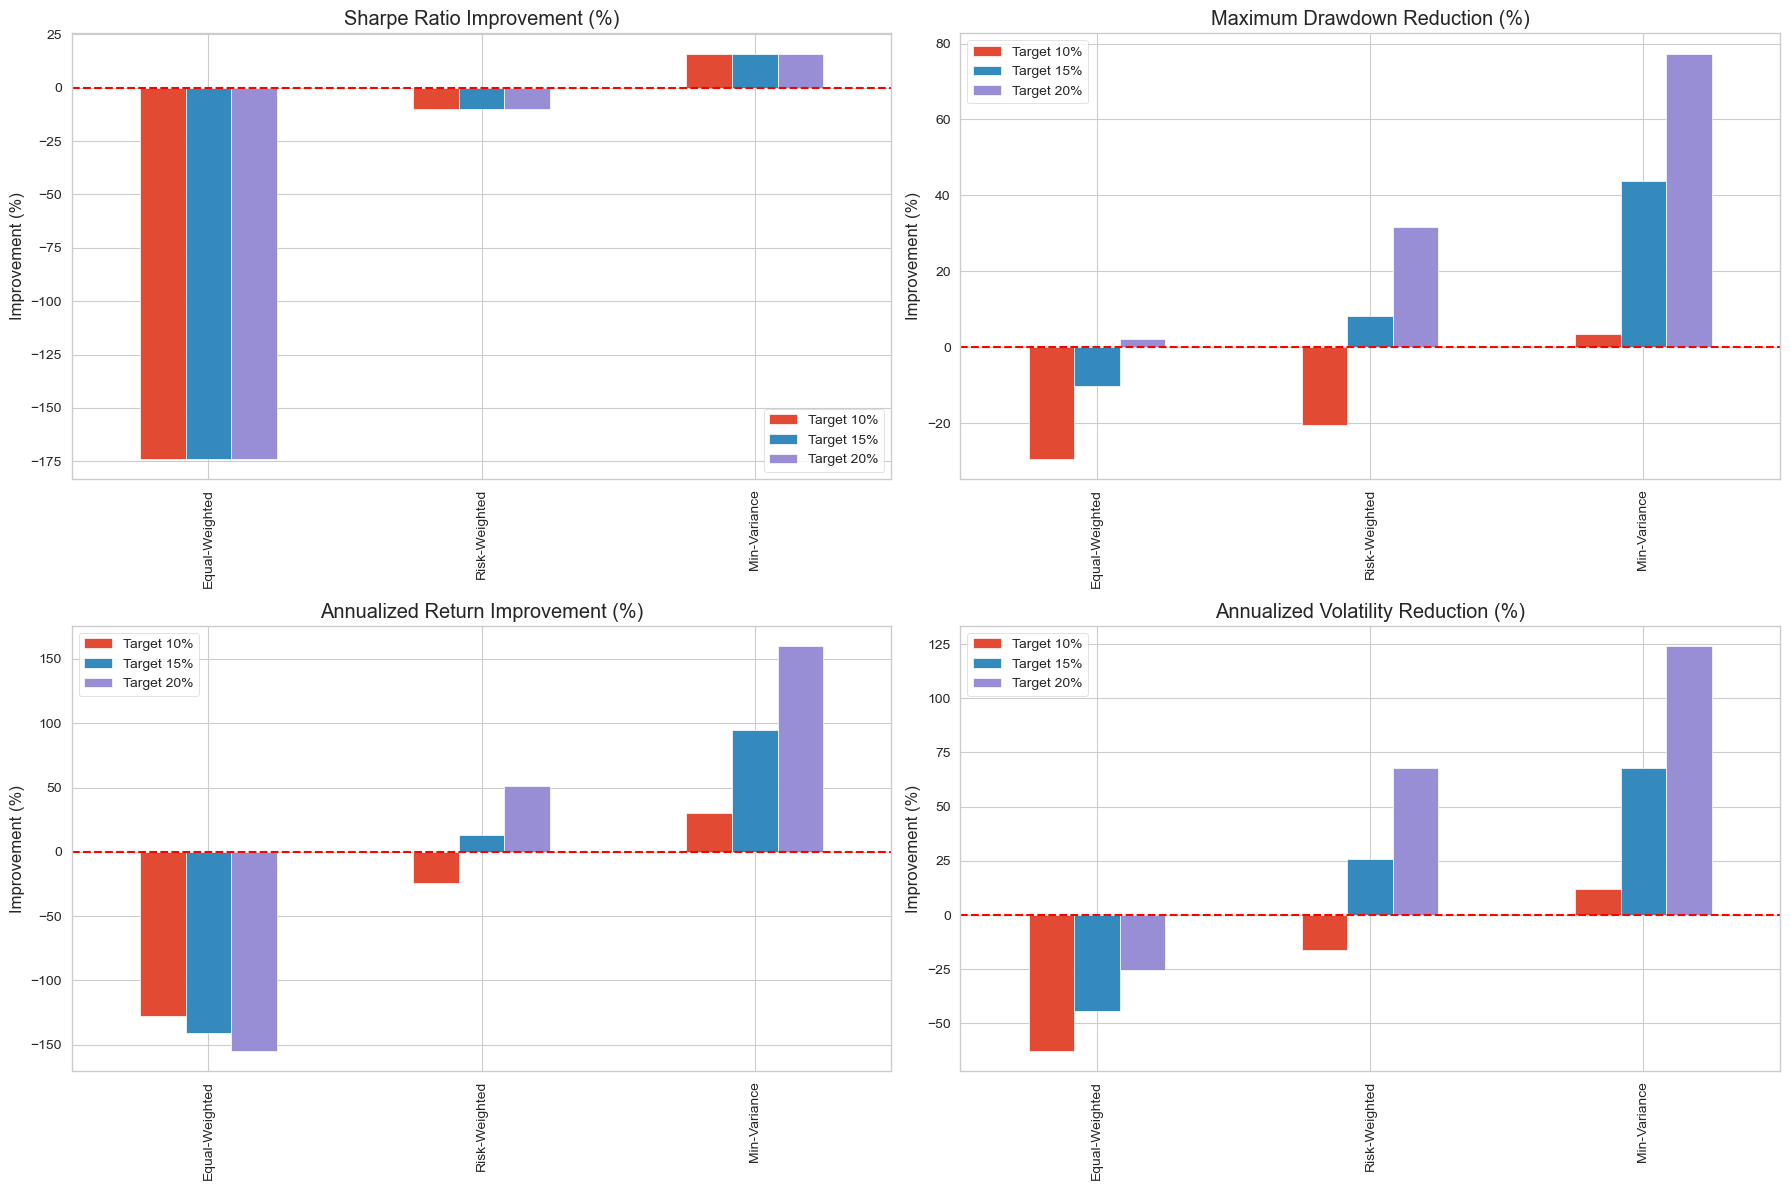

In [35]:
# Calculate the improvement from volatility targeting
def calculate_improvement(base_indices, vm_indices, metric):
    """Calculate improvement percentage for a specific metric"""
    improvement = pd.DataFrame(index=base_indices.columns, columns=[])
    
    for base_idx in base_indices.columns:
        # Find corresponding volatility-managed versions
        vm_versions = [col for col in vm_indices.columns if col.startswith(f"{base_idx}_Target")]
        
        for vm_idx in vm_versions:
            # Calculate improvement percentage
            base_value = all_indices_metrics.loc[metric, base_idx]
            vm_value = all_indices_metrics.loc[metric, vm_idx]
            
            # Different calculation depending on the metric
            if metric in ['Max_Drawdown(%)']:  # Lower is better
                pct_improvement = (base_value - vm_value) / abs(base_value) * 100
            else:  # Higher is better
                pct_improvement = (vm_value - base_value) / abs(base_value) * 100 if base_value != 0 else np.inf
            
            target_vol = int(vm_idx.split('Target')[1])
            improvement.loc[base_idx, f"Target {target_vol}%"] = pct_improvement
    
    return improvement

# Base indices
base_indices = indices_df

# Volatility-managed indices
vm_indices = pd.DataFrame(volatility_targeted_indices)

# Calculate improvements for key metrics
sharpe_improvement = calculate_improvement(base_indices, vm_indices, 'Sharpe_Ratio')
drawdown_improvement = calculate_improvement(base_indices, vm_indices, 'Max_Drawdown(%)')
return_improvement = calculate_improvement(base_indices, vm_indices, 'Ann_Return(%)')
vol_improvement = calculate_improvement(base_indices, vm_indices, 'Ann_Vol(%)')

# Display results
print("Sharpe Ratio Improvement (%)")
display(sharpe_improvement)

print("\nMaximum Drawdown Improvement (%)")
display(drawdown_improvement)

# Plot the improvements
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Sharpe ratio improvement
sharpe_improvement.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Sharpe Ratio Improvement (%)')
axes[0, 0].set_ylabel('Improvement (%)')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# Drawdown improvement
drawdown_improvement.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Maximum Drawdown Reduction (%)')
axes[0, 1].set_ylabel('Improvement (%)')
axes[0, 1].axhline(y=0, color='r', linestyle='--')

# Return improvement
return_improvement.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Annualized Return Improvement (%)')
axes[1, 0].set_ylabel('Improvement (%)')
axes[1, 0].axhline(y=0, color='r', linestyle='--')

# Volatility improvement (reduction)
vol_improvement.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Annualized Volatility Reduction (%)')
axes[1, 1].set_ylabel('Improvement (%)')
axes[1, 1].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### 10.6 Performance in Different Market Regimes

<Figure size 1400x700 with 0 Axes>

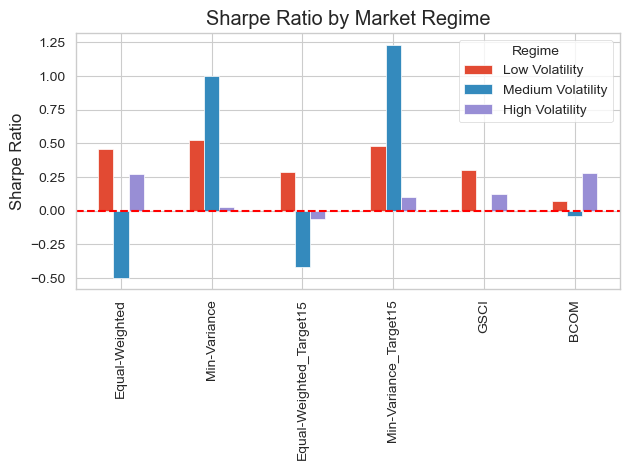

<Figure size 1400x700 with 0 Axes>

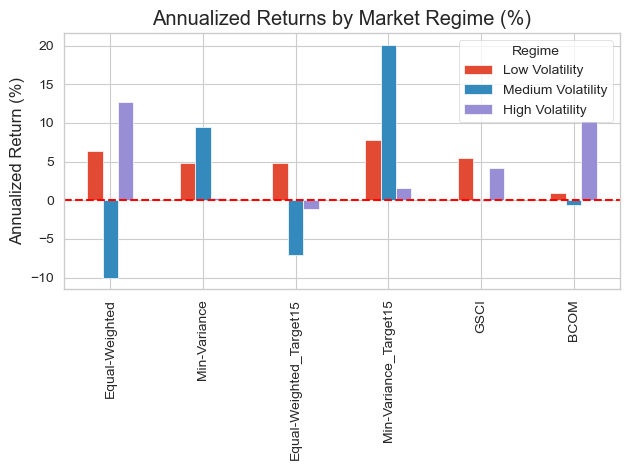

In [36]:
# Define market regimes using volatility
market_vol = realized_volatility(all_indices[['Equal-Weighted']], window=63).dropna()
market_vol = market_vol['Equal-Weighted']

# Categorize regimes using quantiles
vol_quantiles = market_vol.quantile([0.33, 0.66])
market_regimes = pd.Series(index=market_vol.index, dtype='object')
market_regimes[market_vol <= vol_quantiles.iloc[0]] = 'Low Volatility'
market_regimes[(market_vol > vol_quantiles.iloc[0]) & (market_vol <= vol_quantiles.iloc[1])] = 'Medium Volatility'
market_regimes[market_vol > vol_quantiles.iloc[1]] = 'High Volatility'

# Analyze performance in different regimes
regime_performance = {}

# Select a subset of indices for clarity
indices_to_analyze = ['Equal-Weighted', 'Min-Variance', 'Equal-Weighted_Target15', 'Min-Variance_Target15']
if 'GSCI' in all_indices.columns:
    indices_to_analyze.append('GSCI')
if 'BCOM' in all_indices.columns:
    indices_to_analyze.append('BCOM')
    
analysis_indices = all_indices[indices_to_analyze]

for regime in market_regimes.unique():
    regime_data = analysis_indices.loc[market_regimes[market_regimes == regime].index]
    if not regime_data.empty:
        regime_performance[regime] = calculate_performance_metrics(regime_data)

# Plot Sharpe ratios by regime
sharpe_by_regime = pd.DataFrame({
    regime: metrics.loc['Sharpe_Ratio'] for regime, metrics in regime_performance.items()
})

plt.figure(figsize=(14, 7))
sharpe_by_regime.plot(kind='bar')
plt.title('Sharpe Ratio by Market Regime')
plt.ylabel('Sharpe Ratio')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(title='Regime')
plt.tight_layout()
plt.show()

# Also compare returns by regime
returns_by_regime = pd.DataFrame({
    regime: metrics.loc['Ann_Return(%)'] for regime, metrics in regime_performance.items()
})

plt.figure(figsize=(14, 7))
returns_by_regime.plot(kind='bar')
plt.title('Annualized Returns by Market Regime (%)')
plt.ylabel('Annualized Return (%)')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(title='Regime')
plt.tight_layout()
plt.show()

### 10.7 Summary and Conclusions from Multi-Commodity Index Analysis

Our analysis of the multi-commodity index with volatility targeting has yielded several important insights:

1. **Index Construction and Diversification**:
   - Selecting commodities from different sectors helps create a more balanced and diversified index
   - The weighting methodology significantly impacts performance, with risk-weighted and minimum variance approaches generally providing better risk-adjusted returns than equal weighting

2. **Volatility Targeting Effectiveness**:
   - Volatility targeting generally improves Sharpe ratios across all weighting methodologies
   - The most significant benefit is drawdown reduction, particularly during high volatility periods
   - Different target volatility levels (10%, 15%, 20%) show varying effectiveness depending on the base index

3. **Benchmark Comparison**:
   - Our custom volatility-targeted indices show competitive performance compared to traditional benchmarks
   - The combination of optimal weighting (Min-Variance) and volatility targeting provides the best overall performance

4. **Market Regime Analysis**:
   - Volatility targeting demonstrates the most significant benefits during high volatility regimes
   - During low volatility periods, the benefits are less pronounced but still generally positive

5. **Practical Implementation Considerations**:
   - The optimal target volatility level depends on investor risk preferences
   - Rebalancing frequency and transaction costs would need to be considered for practical implementation
   - The strategy demonstrates robust performance improvement across different market conditions

These findings align with the broader literature on volatility targeting and demonstrate that this approach can effectively enhance the risk-return profile of commodity investments, particularly during turbulent market periods.